# Notebook 1 - ERA5 Data Exploration

To better understand the synoptic controls on cloud cover variability, here we will dive into some ERA5 500mb reanalyis. Thanks to Danny for the data!

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import rasterio
from matplotlib.colors import LightSource
import cartopy.crs as ccrs
import matplotlib.cm as cm
import numpy as np

import warnings
warnings.filterwarnings("ignore")

/home/cdalden/miniforge3/envs/goes_env/lib/python3.13/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


In [2]:
path = '/storage/ERA5/'
file = 'ERA5_reanalysis_western_NA_2023_v2.nc'
era5_2023 = xr.open_dataset(path + file)
era5_2023

<xarray.Dataset> Size: 354MB
Dimensions:         (valid_time: 8760, pressure_level: 1, latitude: 41,
                     longitude: 41)
Coordinates:
  * valid_time      (valid_time) datetime64[ns] 70kB 2023-01-01 ... 2023-12-3...
  * pressure_level  (pressure_level) float64 8B 500.0
  * latitude        (latitude) float64 328B 45.0 44.75 44.5 ... 35.5 35.25 35.0
  * longitude       (longitude) float64 328B -110.0 -109.8 ... -100.2 -100.0
    number          int64 8B ...
    expver          (valid_time) <U4 140kB ...
Data variables:
    z               (valid_time, pressure_level, latitude, longitude) float32 59MB ...
    q               (valid_time, pressure_level, latitude, longitude) float32 59MB ...
    t               (valid_time, pressure_level, latitude, longitude) float32 59MB ...
    u               (valid_time, pressure_level, latitude, longitude) float32 59MB ...
    v               (valid_time, pressure_level, latitude, longitude) float32 59MB ...
    vo              (valid_time, pressure_level, latitude, longitude) float32 59MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-02-06T07:27 GRIB to CDM+CF via cfgrib-0.9.1...

In [3]:
# Path to the DEM file
dem_path = "../colorado_dem.tif"

# Open the DEM file
with rasterio.open(dem_path) as src:
    elevation = src.read(1)  # Read the first band (elevation data)
    bounds = src.bounds      # Get the bounds of the DEM
    extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]

# for plotting dem
# Generate terrain shading
ls = LightSource(azdeg=315, altdeg=45)  # Azimuth and altitude of the light source
shaded = ls.shade(elevation, cmap=cm.get_cmap("Greys"), vert_exag=1, blend_mode="overlay")



### Plots

In [4]:
# ds_subset = era5_2023.sel(valid_time='2023-01-01 01:00')
ds_subset = era5_2023.where(era5_2023.valid_time.dt.month == 7, drop=True)
ds_subset = ds_subset.sel(pressure_level=500)
ds_subset = ds_subset.mean(dim='valid_time')

In [5]:
# Extract the data for plotting
z = ds_subset.z/100 # units = dm
spec_hum = ds_subset.q*1000 # units g/kg
vort = ds_subset.vo
temp = ds_subset.t
u = ds_subset.u
v = ds_subset.v

lon = ds_subset.longitude
lat = ds_subset.latitude

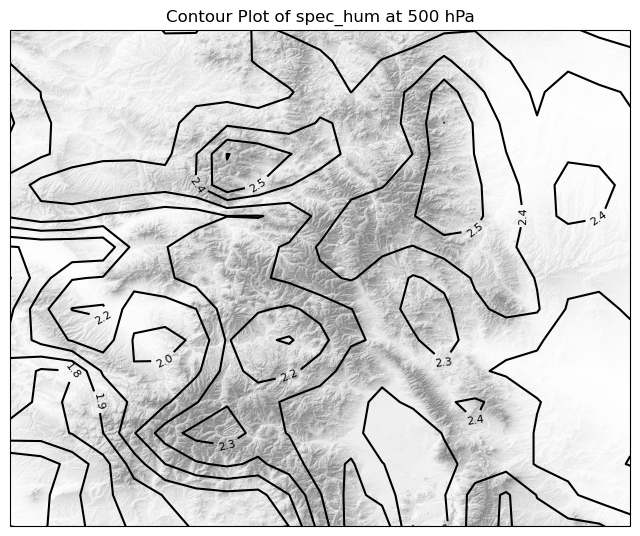

In [6]:
# Create the figure and subplots with Cartopy projection
fig, ax = plt.subplots(figsize=(8,8), subplot_kw={'projection': ccrs.PlateCarree()})
contour = ax.contour(lon, lat, spec_hum, levels=20, colors='black')
ax.imshow(shaded, extent=extent, transform=ccrs.PlateCarree(), origin="upper", alpha=0.5)
ax.clabel(contour, inline=True, fontsize=8)
ax.set_title('Contour Plot of spec_hum at 500 hPa')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude');

### Wind vector plots

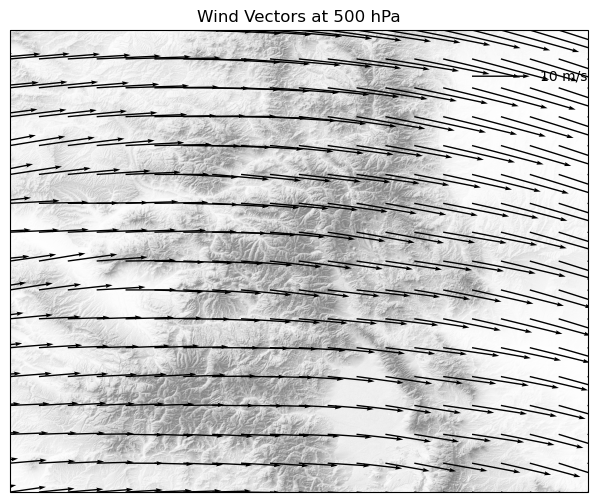

In [7]:
# Create a meshgrid for plotting
lon2d, lat2d = np.meshgrid(lon, lat)

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot wind vectors
q = ax.quiver(lon2d, lat2d, u, v, scale=100, transform=ccrs.PlateCarree())
ax.quiverkey(q, 0.9, 0.9, 10, '10 m/s', labelpos='E')
ax.imshow(shaded, extent=extent, transform=ccrs.PlateCarree(), origin="upper", alpha=0.5)

# Add title and labels
ax.set_title('Wind Vectors at 500 hPa')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude');